In [5]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.stats as st
from statsmodels.stats.diagnostic import kstest_normal
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)

import warnings
warnings.filterwarnings("ignore")

In [6]:
rs = np.random.RandomState(5)
alpha = 0.05

### Консервативность критериев. Нормальное распределение:

In [7]:
def confirm_rate(stat, samples_gen, N_exp):
    success = 0
    for _ in range(N_exp):
        X = samples_gen()
        p_value = stat(X)[1]
        if p_value > alpha:
            success += 1
    return success / N_exp


def confirm_rate_arr(stat, n_arr, samples_gen, N_exp):
    return np.array([confirm_rate(stat, lambda : samples_gen(n), N_exp) for n in n_arr])


def cons_norm(stat, name, ax, N_exp=1500, left_bound=10, right_bound=500):
    n_arr = np.arange(left_bound, right_bound+10, 10)
    succ_arr = confirm_rate_arr(stat, n_arr, lambda n : np.random.normal(size=n), N_exp)
    ax.plot(n_arr, succ_arr, label="Accept rate")
    ax.plot([left_bound, right_bound], [1-alpha, 1-alpha], label="0.95")
    avg_rate = np.average(succ_arr)
    ax.plot([left_bound, right_bound], [avg_rate, avg_rate], ls='--', label="avg rate")
    ax.set_title(name)
    ax.set_xlabel('dataset_size')
    return succ_arr*N_exp

Зависимость частоты принятия верной гипотезы от длины выборки

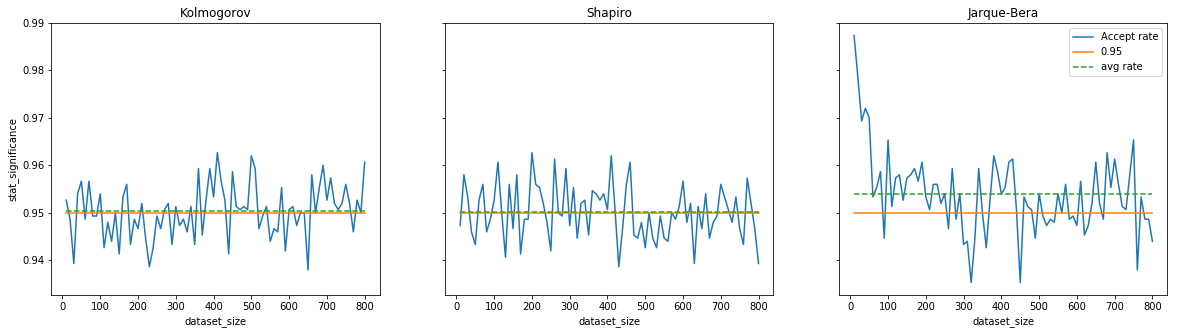

In [8]:
crit = {'Kolmogorov':kstest_normal, 'Shapiro':st.shapiro, 'Jarque-Bera':st.jarque_bera}

np.random.seed(10)
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].set_ylabel('stat_significance')
succ_arr = []
for i, (name, stat) in enumerate(crit.items()):
    succ_arr.append(cons_norm(stat, name, axs[i], right_bound=800))
plt.legend()

plt.show()


У всех критериев процент принятых гипотез > 95 . Построим доверительные интервалы для вероятности принять основную гипотезу

In [9]:
from statsmodels.stats.proportion import proportion_confint
for i, (name, stat) in enumerate(crit.items()):
    print(name, proportion_confint(np.sum(succ_arr[i]), succ_arr[i].shape[0]*1500, method='beta'))


Kolmogorov (0.9491649030636249, 0.9516299392362216)
Shapiro (0.948895117813876, 0.9513664043209815)
Jarque-Bera (0.9527405157616923, 0.9551208184900979)


Исходя из этих данных можно утверждать только консервативность критерия Харке-Бера

### Мощности критериев

Для расчета мощностей критериев будем полагать альтернативой то, что выборки имеют распределение Лапласа, усеченное нормальное, стьюдента

In [10]:
def plot_power(stat, name, ax, distrib, N_exp=1500, left_bound=10, right_bound=500):
    n_arr = np.arange(left_bound, right_bound+10, 10)
    power_arr = 1 - confirm_rate_arr(stat, n_arr, distrib, N_exp)         
    plt.plot(n_arr, power_arr, label=name)

    
def plot_power_altogether(distrib, N_exp=1500) : 
    for i, (name, stat) in enumerate(crit.items()):
        plot_power(stat, name, axs[i], distrib)
    plt.xlabel('dataset_size')
    plt.ylabel('power')
    plt.title("Зависимость мощности от длины выборки")
    plt.legend()
    plt.show()

#### Альтернатива - распределение Лапласа:

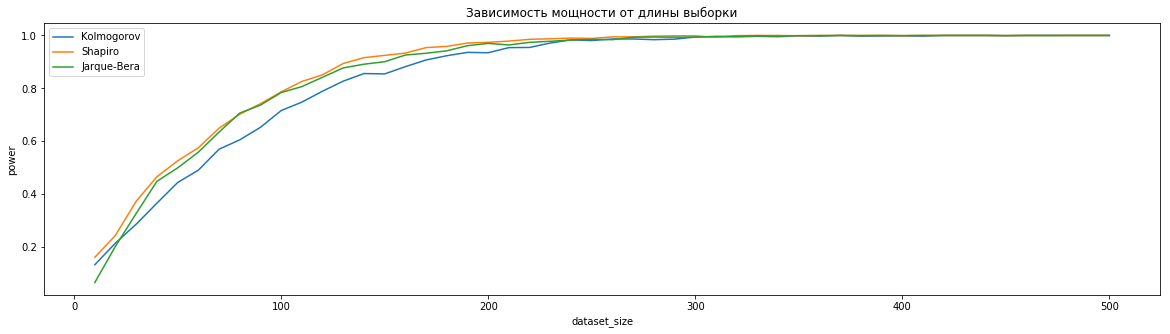

In [11]:
plot_power_altogether(lambda n : np.random.laplace(size=n))

Все критерии ведут себя достаточно хорошо

#### Альтернатива - распределение Стьюдента:

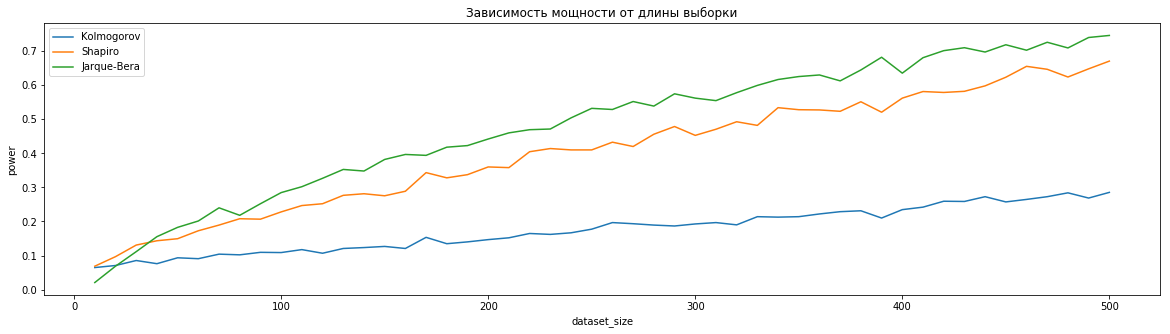

In [12]:
plot_power_altogether(lambda n : np.random.standard_t(10, size=n))

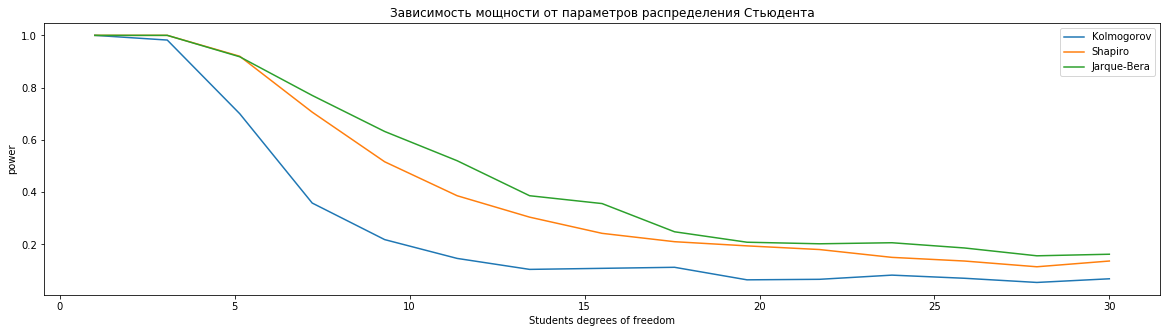

In [13]:
def power_for_params(distrib, params):
    for i, (name, stat) in enumerate(crit.items()):
        power_arr = [1 - confirm_rate(stat, lambda:distrib(param), N_exp=500) for param in params]
        plt.plot(params, power_arr, label=name)
    plt.ylabel('power')
    plt.legend()

power_for_params(lambda df : np.random.standard_t(df, size=300), np.linspace(1, 30, 15))
plt.xlabel('Students degrees of freedom')
plt.title("Зависимость мощности от параметров распределения Стьюдента")
plt.show()


При длине выборки 300 заметна разница при количестве степеней свободы  $\geq$  3 . При альтернативном распределении Стьюдента лучше всего работает Харке-Бера

#### Альтернатива - усеченное нормальное распределение:

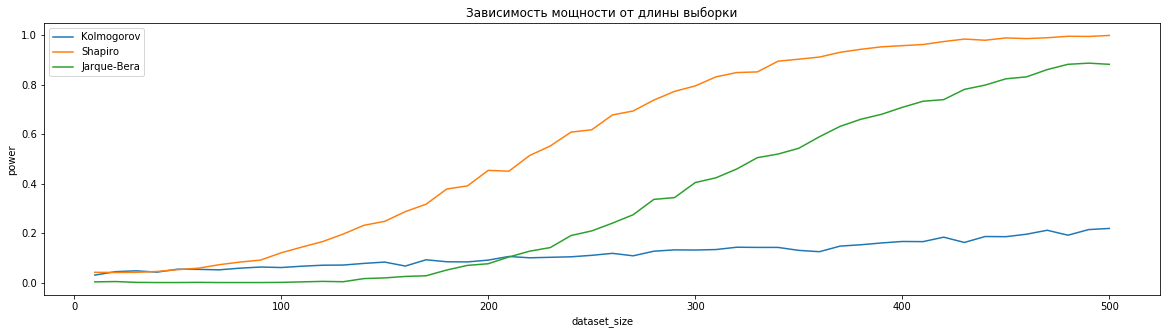

In [14]:
plot_power_altogether(lambda n : st.truncnorm.rvs(-2, 2, size=n))

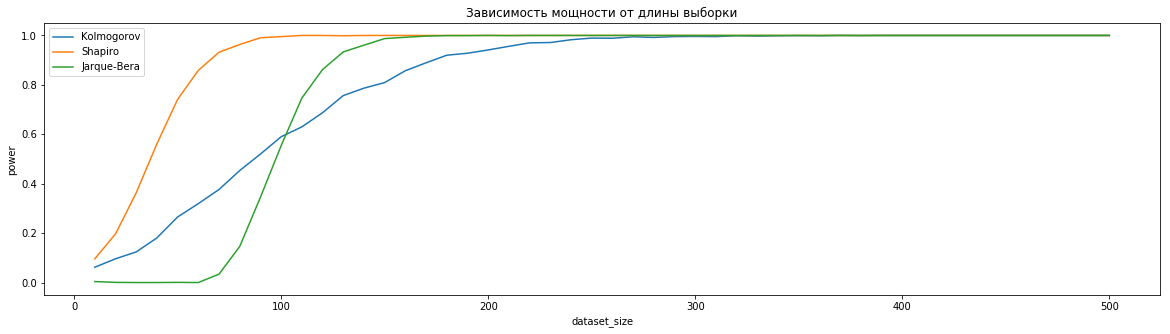

In [15]:
plot_power_altogether(lambda n : st.truncnorm.rvs(-0.2, 0.2, size=n))

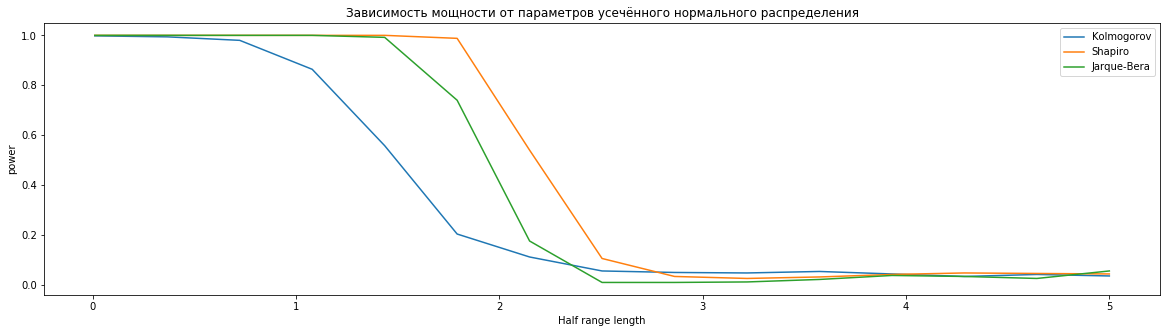

In [16]:
power_for_params(lambda a : st.truncnorm.rvs(-a, a, size=300), np.linspace(0.01, 5, 15))
plt.xlabel('Half range length')
plt.title("Зависимость мощности от параметров усечённого нормального распределения")
plt.show()

При альтернативном усеченном нормальном распределении лучше всего работает Шапиро